In [7]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import sys
import time
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import confusion_matrix as cm
from sklearn.preprocessing import OneHotEncoder as OHE
from netcal.scaling import LogisticCalibration as LC 
from netcal.binning import IsotonicRegression as IR 
from netcal.binning import BBQ

From the ADNIMERGE file, select the baseline cases and restrict the dataset to diagnosis, sex, age, hippocamppus, MMSE and ICV at baseline along with subject ID (RID)

In [111]:
df_adni = pd.read_csv('ADNI/ADNIMERGE.csv')
df_adni = df_adni.sort_values('EXAMDATE').drop_duplicates('RID')
df_adni['SEX'] = np.where(df_adni['PTGENDER']=='Female',1,0)
df_adnia = df_adni.dropna(subset=['DX_bl','SEX','AGE','Hippocampus_bl','MMSE_bl','ICV_bl'])
le = LE()
diag = le.fit_transform(df_adnia['DX_bl'])
df_adnia['diagnosis'] = diag

/var/folders/9x/f7zq7s_d1fv5z99dsps_gk2m0000gn/T/ipykernel_25858/3545597063.py:1: DtypeWarning: Columns (19,20,21,50,51,104,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  df_adni = pd.read_csv('ADNI/ADNIMERGE.csv')
/var/folders/9x/f7zq7s_d1fv5z99dsps_gk2m0000gn/T/ipykernel_25858/3545597063.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adnia['diagnosis'] = diag


In [8]:
class DatasetADNI(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, dataframe, list_values):
        'Initialization'
        self.labels = np.asarray(dataframe['diagnosis'])
        self.list_IDs = np.asarray(dataframe['RID'])
        self.list_values = list_values
        self.dataframe = dataframe

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = np.asarray(self.dataframe.iloc[index][self.list_values])
        y = self.labels[index]
        sample = {'data': X, 'label': y}

        return sample

Let's create a validation/calibration and a test subset of the original dataset

In [14]:
valid = df_adnia.sample(frac=0.1, replace=False)
remain = df_adnia.drop(valid.index)
test = remain.sample(frac=0.2, replace=False)
train = remain.drop(test.index)
test = df_adnia.sample(frac=0.2, replace=False)

We now standardise the range of values of the features and create the associated dataframes

In [15]:
MMS = MinMaxScaler()
train_mms = MMS.fit_transform(train[['Hippocampus_bl','ICV_bl','AGE','MMSE_bl']])
MMS.fit(train[['Hippocampus_bl','ICV_bl','AGE','MMSE_bl']])

MinMaxScaler()

In [16]:
test_mms = MMS.transform(test[['Hippocampus_bl','ICV_bl','AGE','MMSE_bl']])
valid_mms = MMS.transform(valid[['Hippocampus_bl','ICV_bl','AGE','MMSE_bl']])

In [17]:
dict_data = {'RID': train['RID'],'diagnosis': train['diagnosis'], 'sex': train['SEX'], 'hipp':train_mms[:,0], 'icv': train_mms[:,1],'age':train_mms[:,2], 'mmse': train_mms[:,3]}
df_train = pd.DataFrame(dict_data)

In [18]:
dict_data = {'RID': test['RID'],'diagnosis': test['diagnosis'], 'sex': test['SEX'], 'hipp':test_mms[:,0], 'icv': test_mms[:,1],'age':test_mms[:,2], 'mmse': test_mms[:,3]}
df_test = pd.DataFrame(dict_data)

In [19]:
dict_data = {'RID': valid['RID'],'diagnosis': valid['diagnosis'], 'sex': valid['SEX'], 'hipp':valid_mms[:,0], 'icv': valid_mms[:,1],'age':valid_mms[:,2], 'mmse': valid_mms[:,3]}
df_valid = pd.DataFrame(dict_data)

In [81]:
list_feat = ['sex','hipp','age','icv','mmse']

In [20]:
df_train.describe()

,RID,diagnosis,sex,hipp,icv,age,mmse
count,1491.000000,1491.000000,1491.000000,1491.000000,1491.000000,1491.000000,1491.000000
mean,3772.873239,2.022803,0.479544,0.508212,0.220118,0.560118,0.805190
std,2386.338918,1.317722,0.499749,0.151916,0.087060,0.184098,0.200107
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1124.500000,1.000000,0.000000,0.406898,0.158975,0.438596,0.692308
50%,4414.000000,2.000000,0.000000,0.522936,0.213290,0.563910,0.846154
75%,6174.000000,3.000000,1.000000,0.609025,0.273642,0.689223,0.923077
max,7100.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
dataset = DatasetADNI(df_train, ['hipp','icv','age','mmse','sex'])

Create a small network with 3 fully connected layers and leaky ReLu as activation function. The intermediary feature number should be 16 and 32

In [ ]:
def initialize_weights(*models):
    for model in models:
        for module in model.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()

In [23]:

class MultiFCn(nn.Module):
    def __init__(self, num_classes, num_channels):
        super(MultiFCn, self).__init__()
        self.fc1 = nn.Linear(num_channels, 16)
        self.fc2 = nn.Linear(16,32)
        self.fc3 = nn.Linear(32, num_classes)
        initialize_weights(self)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return x

In [26]:

dataloader = DataLoader(dataset, shuffle=True, batch_size=20)

In [27]:
dataset_test = DatasetADNI(df_test, ['hipp','icv','age','mmse','sex'])
dataset_valid = DatasetADNI(df_valid, ['hipp','icv','age','mmse','sex'])
testloader = DataLoader(dataset_test, shuffle=False, batch_size=20)
validloader = DataLoader(dataset_valid, shuffle=False, batch_size=20)

In [28]:

def cross_entropy(pred, label, weight=None, reduction='mean',
                  avg_factor=None):
    # element-wise losses
    # print((pred[:,:]*weight).sum(), label.sum(), pred.shape)
    loss = F.cross_entropy(pred, label.type(torch.LongTensor), reduction=reduction)

    # apply weights and do the reduction
    if weight is not None:
        weight = weight.float()
        loss = (loss * weight).sum()/weight.sum()

    return loss

Let's train our network for 300 epochs

/var/folders/9x/f7zq7s_d1fv5z99dsps_gk2m0000gn/T/ipykernel_25858/659818287.py:5: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(module.weight)


100%|██████████| 75/75 [00:00<00:00, 439.12it/s]


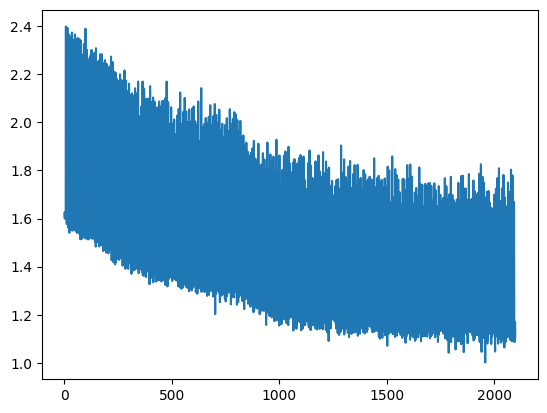

In [29]:

net = MultiFCn(5,5)
number_of_epochs = 300
optimizer = optim.Adam(net.parameters(), lr=1e-4)
list_loss = []
running_loss = 0
for epoch in range(number_of_epochs):
    net.train()
    indb = 0
    with tqdm(total=len(dataloader), file=sys.stdout) as pbar:
        start_time = time.time()
        for (i,sample) in enumerate(dataloader):
            output = net(sample['data'].float())
            loss = cross_entropy(output,sample['label'])
            net.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # print(loss.item())
            indb += 1
            if i%10 == 9:
                if i%50 == 49:
                    print('Epoch ', epoch, ' Loss ', running_loss/10)
                list_loss.append(running_loss/10)
                running_loss = 0
            pbar.update(1)
from matplotlib import pyplot as plt
plt.plot(np.asarray(list_loss))

As an alternative let's build a random forest classifier


In [83]:
rfc = RFC()
rfc.fit(df_train[list_feat], df_train['diagnosis'])
pred_rfc = rfc.predict_proba(df_test[list_feat])
pred_rfc_val = rfc.predict_proba(df_valid[list_feat])
final_class_rfc = np.argmax(pred_rfc,1)

In [30]:
def get_whole_test_output(model, testloader):
    model.eval()
    sig = nn.Softmax(dim=1)
    list_output = []
    list_labels = []
    for (i, sample) in enumerate(testloader):
        labels = sample['label']
        output = sig(model(sample['data'].float()))
        list_output.append(output)
        list_labels.append(labels)
    tot_out = torch.cat(list_output)
    tot_lab = torch.cat(list_labels)
    return tot_out, tot_lab

In [112]:
cm(final_class_rfc, lab)

array([[61,  0,  1,  4,  0],
       [ 0, 96,  6,  7,  4],
       [ 1,  4, 52,  1,  2],
       [ 7,  3,  4, 98,  3],
       [ 0,  3,  5,  2, 50]])

In [114]:
out_pred, out_lab = get_whole_test_output(net, testloader)
out_pred_val, out_lab_val = get_whole_test_output(net, validloader)
pred_net = out_pred.detach().numpy()
val_net = out_pred_val.detach().numpy()
lab = out_lab.numpy()

In [115]:
final_class = np.argmax(pred_net,1)

In [33]:

cm(final_class,lab)

array([[48,  0,  2,  9,  0],
       [ 1, 76, 28, 23, 38],
       [ 1,  4,  7,  3,  3],
       [19, 16, 27, 76,  6],
       [ 0, 10,  4,  1, 12]])

Let's implement the class ECE and the brier score and apply it to our two types of prediction

In [107]:
def class_ece_ing(prob, pred, lab, bins=10):

    numb_classes = prob.shape[1]
    step = 1/bins
    a_bm = np.zeros([numb_classes, bins])
    a_fin = np.zeros([numb_classes, bins])
    a_conf = np.zeros([numb_classes, bins])
    a_acc = np.zeros([numb_classes, bins])
    for vc in range(numb_classes):
        prob_tmp = prob[:,vc]
        for k in range(bins):
            border_inf = k * step
            border_sup = (k+1)*step
            if border_sup < 1:
                selected_ind = np.where(np.logical_and(prob_tmp>=border_inf, prob_tmp<border_sup))
            else:
                selected_ind = np.where(np.logical_and(prob_tmp>=border_inf, prob_tmp<=border_sup))
            bm = np.asarray(selected_ind).size
            
            a_bm[vc,k] = bm
            if bm == 0:
                a_conf[vc, k] = 0
                a_acc[vc, k] = 0
                a_fin[vc, k] = 0
            else:
                prob_bm = prob_tmp[selected_ind]
                conf_bm = np.mean(prob_bm)
                pred_bm = pred[selected_ind]
                pred_bin = np.where(pred_bm==vc, np.ones_like(pred_bm), np.zeros_like(pred_bm))
                
                lab_bm = lab[selected_ind]
                lab_bin = np.where(lab_bm==vc, np.ones_like(lab_bm), np.zeros_like(pred_bm))
                numb_true = np.where(lab_bin * pred_bin == 1, np.ones_like(lab_bm), np.zeros_like(pred_bm))
                
                acc_bm = np.mean(numb_true)
                a_conf[vc, k] = conf_bm
                a_acc[vc, k] = acc_bm
                a_fin[vc, k] = np.abs(acc_bm - conf_bm)/np.size(prob)*bm
    return  a_fin, a_bm, a_conf, a_acc
        

In [35]:
def brier_score(prob, lab_ohe):
    diff = np.square(prob - lab_ohe)
    bs = np.sum(diff)/diff.shape[0]
    return bs

In [42]:

ohe = OHE(sparse_output=False)
label_ohe = ohe.fit_transform(np.reshape(out_lab,[-1,1]))

ohe_val = OHE(sparse_output=False)
label_ohe_val= ohe_val.fit_transform(np.reshape(out_lab_val,[-1,1]))

In [38]:
brier_score(pred_net, label_ohe)

0.6063839464612178

In [102]:
brier_score(pred_rfc, label_ohe)

0.24621207729468597

Let's compare the calibration of output probabilities for the network and the random forest

<BarContainer object of 10 artists>

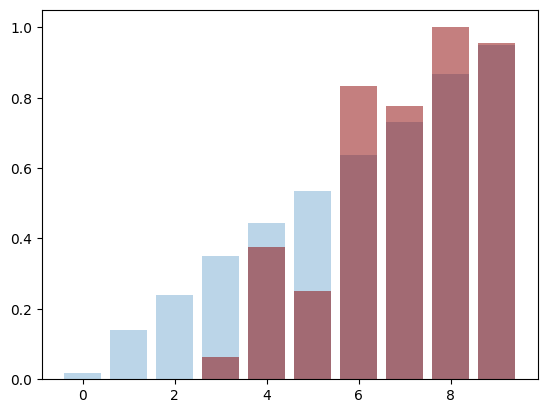

In [116]:
net_fin, net_bm, net_conf, net_acc = class_ece_ing(pred_net, final_class, lab)
plt.bar(np.arange(10),net_conf[0,:],alpha=0.3)
plt.bar(np.arange(10),net_acc[0,:], alpha=0.5, color='darkred')

<BarContainer object of 10 artists>

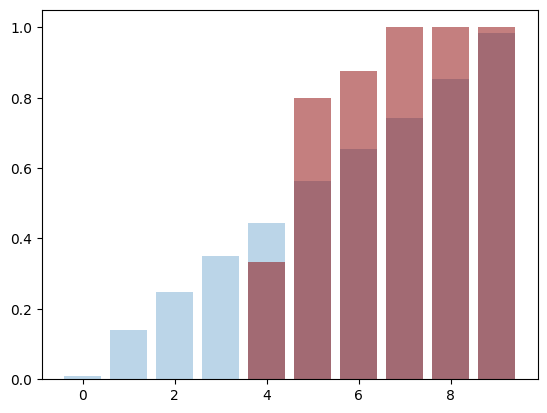

In [117]:
rfc_fin, rfc_bm, rfc_conf, rfc_acc = class_ece_ing(pred_rfc, final_class_rfc, lab)
plt.bar(np.arange(10),rfc_conf[0,:],alpha=0.3)
plt.bar(np.arange(10),rfc_acc[0,:], alpha=0.5, color='darkred')

In [62]:


ir = IR()
lc = LC()
bbq = BBQ()
ir.fit(out_pred_val.detach().numpy(), label_ohe_val)
lc.fit(out_pred_val.detach().numpy(),label_ohe_val)
bbq.fit(out_pred_val.detach().numpy(), label_ohe_val)
pred_ir = ir.transform(pred_net)
pred_lc = lc.transform(pred_net)
pred_bbq = bbq.transform(pred_net)


100%|██████████| 42/42 [00:00<00:00, 9934.62it/s]


In [104]:


ir_rfc = IR()
lc_rfc = LC()
bbq_rfc = BBQ()
ir_rfc.fit(pred_rfc_val, label_ohe_val)
lc_rfc.fit(pred_rfc_val,label_ohe_val)
bbq_rfc.fit(pred_rfc_val, label_ohe_val)
pred_ir_rfc = ir_rfc.transform(pred_rfc)
pred_lc_rfc = lc_rfc.transform(pred_rfc)
pred_bbq_rfc = bbq_rfc.transform(pred_rfc)


100%|██████████| 42/42 [00:00<00:00, 10339.89it/s]


In [108]:


list_fini, list_bmi, list_confi, list_acci = class_ece_ing(pred_ir, pred, lab)
list_finl, list_bml, list_confl, list_accl = class_ece_ing(pred_lc, pred, lab)
list_finb, list_bmb, list_confb, list_accb = class_ece_ing(pred_bbq, pred, lab)

rfc_finb, rfc_bmb, rfc_confb, rfc_accb = class_ece_ing(pred_bbq_rfc, final_class_rfc, lab)
rfc_fini, rfc_bmi, rfc_confi, rfc_acci = class_ece_ing(pred_ir_rfc, final_class_rfc, lab)

In [ ]:
rfc

<BarContainer object of 10 artists>

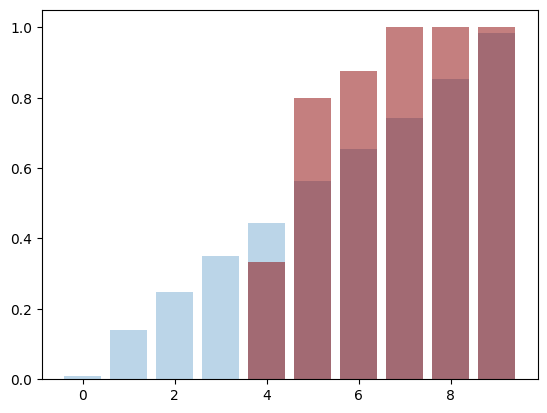

In [101]:
plt.bar(np.arange(10),rfc_conf[0,:],alpha=0.3)
plt.bar(np.arange(10),rfc_acc[0,:], alpha=0.5, color='darkred')

<BarContainer object of 10 artists>

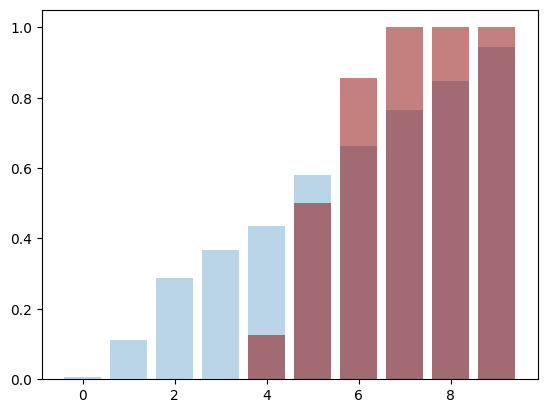

In [109]:
plt.bar(np.arange(10),rfc_confi[0,:],alpha=0.3)
plt.bar(np.arange(10),rfc_acci[0,:], alpha=0.5, color='darkred')

<BarContainer object of 10 artists>

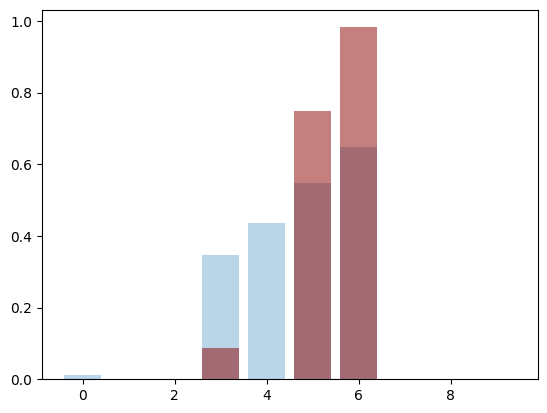

In [110]:
plt.bar(np.arange(10),rfc_confb[0,:],alpha=0.3)
plt.bar(np.arange(10),rfc_accb[0,:], alpha=0.5, color='darkred')

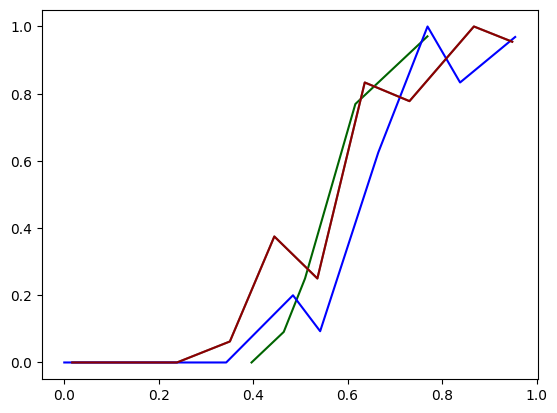

In [68]:
plt.plot(list_confb, list_accb, color='darkgreen')
plt.plot(list_conf, list_acc, color='grey')
plt.plot(list_confi[~np.isnan(list_confi)], list_acci[~np.isnan(list_acci)], color='blue')
plt.plot(list_confl, list_accl, color='darkred')

In [ ]:
# Part 3 Conformal Prediction

Let's look into conformal predictions for both our RF output and our network output

In [126]:
out_pred_val, out_lab_val = get_whole_test_output(net, validloader)
val_smx = out_pred_val.detach().numpy()
lab_val = out_lab_val.numpy()
test_smx = pred_net
n = val_smx.shape[0]
val_scores = 1- val_smx[np.arange(n),lab_val]
alpha=0.1
q = np.ceil((n+1)*(1-alpha)/n*100)/100
qhat = np.quantile(val_scores,q)
pred_test_set = test_smx >= (1-qhat)

In [127]:
val_scores_rfc = 1 - pred_rfc_val[np.arange(n),lab_val]
qhat_rfc = np.quantile(val_scores_rfc, q)
pred_test_set_rfc = pred_rfc >= (1-qhat)

In [120]:
qhat

0.8424728846549988

In [121]:
pred_test_set

array([[False,  True,  True,  True,  True],
       [False,  True,  True,  True, False],
       [ True, False, False, False, False],
       ...,
       [ True, False, False, False, False],
       [False,  True,  True,  True, False],
       [False,  True,  True,  True,  True]])

In [146]:
size_pred_test = np.sum(pred_test_set.astype(int),1)
np.unique(size_pred_test, return_counts=True)

(array([1, 2, 3, 4]), array([ 46, 120, 126, 122]))

In [128]:
size_pred_test_rfc = np.sum(pred_test_set_rfc.astype(int),1)
np.unique(size_pred_test_rfc, return_counts=True)

(array([1, 2, 3, 4]), array([194, 174,  42,   4]))

Let's evaluate the quality of our conformal prediction according to the size coverage index metric

In [123]:
def ssc(pred_test_set, label_ohe):
    comp_agreement = np.diag(np.dot(pred_test_set, label_ohe.T))
    size_pred_test = np.sum(pred_test_set.astype(int),1) 
    list_valid = []
    for k in range(1,5):
        ind = np.where(size_pred_test == k)
        valid_set_mean = np.mean(comp_agreement[ind])
        list_valid.append(valid_set_mean)
    return list_valid
    

In [124]:
ssc(pred_test_set, label_ohe)

[0.9090909090909091,
 0.8421052631578947,
 0.8934010152284264,
 0.9830508474576272]

In [129]:
ssc(pred_test_set_rfc, label_ohe)

[0.9742268041237113, 0.9310344827586207, 0.8571428571428571, 1.0]